In [2]:
import pandas as pd
from collections import Counter
import tqdm
import re
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import functools
import sys

In [3]:
dftrain = pd.read_csv("data/train_task1_latest.csv", encoding='utf-8')
dftest = pd.read_csv("data/sdsj_A_test.csv", encoding='utf-8')

### TODO:
* crossval - remove paragraphs from train in val
* https://nlpub.ru/Russian_Distributional_Thesaurus
* ~~https://slundberg.github.io/shap/notebooks/Census+income+classification+with+LightGBM.html~~
* https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
* Разобрать фичи тф-идф
* похожесть вопроса с параграфом и с отдельными предложениями параграфа
* почистить данные
   
### Notes:
* tf-idf with lemmed words is just +0.01 on lb
* len_intersection and len_question are the best now


In [4]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
# morph.parse('передний')[0].normal_form

def uniq_words_lemmed(text):
    return set([morph.parse(x)[0].normal_form for x in re.findall("\w+", text, re.UNICODE)])

    
def uniq_words(text):
    return set(re.findall("\w+", text, re.UNICODE))


def calculate_idfs(data):
    counter_paragraph = Counter()
    uniq_paragraphs = data['paragraph'].unique()
    for paragraph in tqdm.tqdm(uniq_paragraphs, desc="calc idf"):
        set_words = uniq_words_lemmed(paragraph)
        counter_paragraph.update(set_words)
        
    num_docs = uniq_paragraphs.shape[0]
    idfs = {}
    
    for word in counter_paragraph:
        idfs[word] = np.log(num_docs / counter_paragraph[word])
    return idfs
idfs = calculate_idfs(dftrain)


calc idf: 100%|██████████| 9078/9078 [04:27<00:00, 33.95it/s]


In [5]:
for name, df in [('train', dftrain), ('test', dftest)]:
    for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        question = uniq_words(row.question)
        paragraph = uniq_words(row.paragraph)
        df.loc[index, 'len_paragraph'] = len(paragraph)
        df.loc[index, 'len_question'] = len(question)
        df.loc[index, 'len_intersection'] = len(paragraph & question)
        df.loc[index, 'idf_question'] = np.sum([idfs.get(word, 0.0) for word in question])
        df.loc[index, 'idf_paragraph'] = np.sum([idfs.get(word, 0.0) for word in paragraph])
        df.loc[index, 'idf_intersection'] = np.sum([idfs.get(word, 0.0) for word in paragraph & question])

build features for test: 100%|██████████| 74286/74286 [05:21<00:00, 231.32it/s]


TRAIN shape: (59699,) TEST shape: (59699,)
0.987287308974
            feature     importance
2  len_intersection  161081.824369
1      len_question  135956.774175
0     len_paragraph    9310.043144


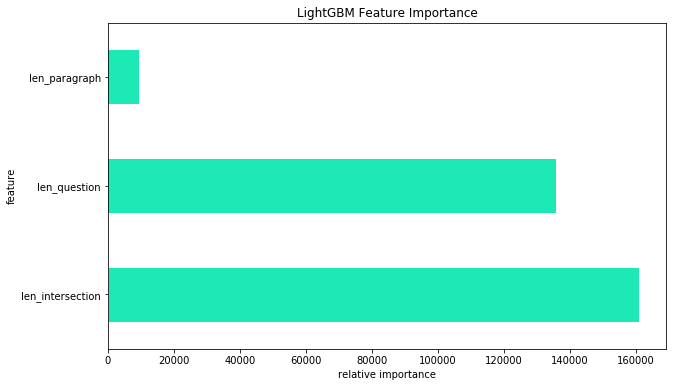

TRAIN shape: (59699,) TEST shape: (59699,)
0.989157229234
            feature     importance
2  len_intersection  160006.006825
1      len_question  135202.459790
0     len_paragraph   12008.565751


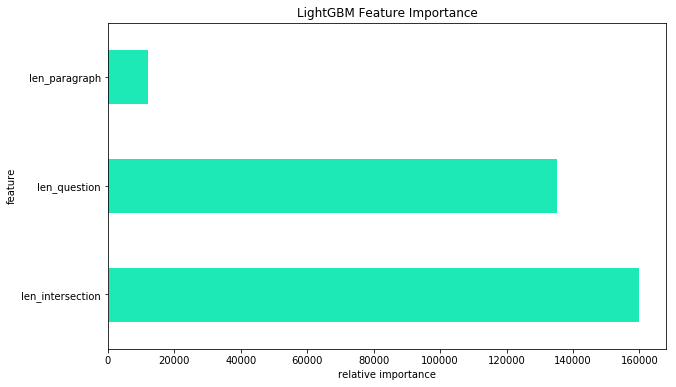

In [15]:
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

columns = ['len_paragraph', 'len_question', 'len_intersection']#, 'idf_question', 'idf_paragraph', 'idf_intersection']
# model = GradientBoostingClassifier().fit(dftrain[columns], dftrain['target'])
# dftest['prediction'] = model.predict_proba(dftest[columns])[:, 1]

X = dftrain[columns]
y = dftrain['target']
groups = dftrain['paragraph']
group_kfold = GroupKFold(n_splits=2)
group_kfold.get_n_splits(X, y, groups)


import lightgbm as lgb
import shap
params = {
#     "max_bin": 512,
    "learning_rate": 0.1,
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
#     "num_leaves": 10,
    "verbose": -1,
#     "min_data": 100,
#     "boost_from_average": True
}

plot = 1
for train_index, test_index in group_kfold.split(X, y, groups):
    print("TRAIN shape:", train_index.shape, "TEST shape:", test_index.shape)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_test, label=y_test)
    model = lgb.train(params, d_train, valid_sets=[d_valid], verbose_eval=False)
    y_pred = model.predict(X_test.values)
    print(roc_auc_score( y_test.values, y_pred))
    
    df_fi = pd.DataFrame(model.feature_name(), columns=['feature'])
    df_fi['importance'] = list(model.feature_importance('gain'))
    df_fi.sort_values('importance', ascending=False, inplace=True)
    print(df_fi)
    if plot:
        plt.figure()
        df_fi.head(10).plot(kind='barh',
                            x='feature',
                            y='importance',
                            sort_columns=False,
                            legend=False,
                            figsize=(10, 6),
                            facecolor='#1DE9B6',
                            edgecolor='white')

        plt.title('LightGBM Feature Importance')
        plt.xlabel('relative importance')
        plt.show()
#     print(model.predict(X_test.values)[:100])

In [16]:
model = lgb.train(params, lgb.Dataset(X, y))
dftest['prediction'] = model.predict(dftest[columns])
dftest[['paragraph_id', 'question_id', 'prediction']].to_csv("../../Downloads/prediction.csv", index=False)